# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 
from jaxopt import LBFGS

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops, oasis
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
jax.__version__

'0.3.24'

In [4]:
cd /home/bt387/project/simple_cryoem/nb

/gpfs/gibbs/project/lederman/bt387/simple_cryoem/nb


In [5]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  74.36 sec.


In [6]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[ 18720  60093  53249 102196  43608  18973  24325  65695  39526  50914]


In [7]:
out_dir = out_dir = '../data/out_dev/'

nx_crop = 192 #64 #8 #192 # 128 # 64
N = 50000 #10000 #200 #104000 #80000 # 20000

idx = idx_full[:N]

In [8]:
processed_data = preprocess(imgs0, params0, nx_crop = nx_crop, idx = idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
N0 = 105519
idx provided
N = 50000
Taking FFT of the images:
Batch 1/10  13.32 sec.
Batch 2/10  13.33 sec.
Batch 3/10  13.35 sec.
Batch 4/10  13.32 sec.
Batch 5/10  13.29 sec.
Batch 6/10  13.32 sec.
Batch 7/10  13.32 sec.
Batch 8/10  13.38 sec.
Batch 9/10  13.36 sec.
Batch 10/10  13.30 sec.
FFT done. Time:  165.76 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (50000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [9]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

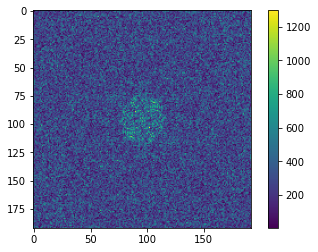

In [10]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [11]:
del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [12]:
# Apply mask to images

apply_mask = True

if apply_mask:
    #mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

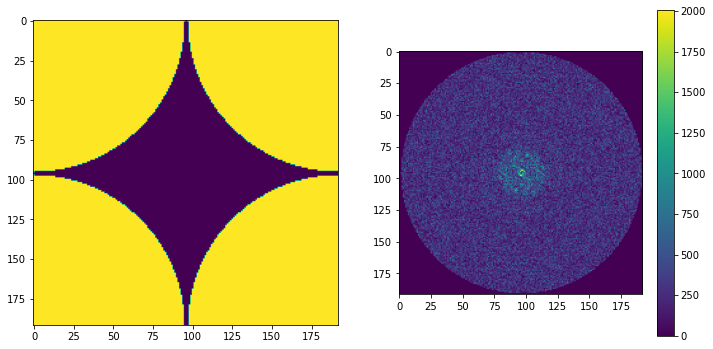

In [13]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.subplot(1,2,2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop,nx_crop]))));plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [14]:
imgs_f.shape

(50000, 36864)

In [15]:
alpha =  1e-8 #1e-9 #1e-5 #1e-9 #1e-9 # 1e-5
interp_method = "tri"

#slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)

slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

grad_func, loss_func, hvp_func, loss_px_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise)

In [ ]:
n_epochs = 400 
batch_sz = 100
n_batch = N // batch_sz

zD0z = np.zeros([nx,nx,nx])

#zD0z = [] 

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

for i in range(n_epochs):
    print(f"Epoch {i}")
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N), n_batch)
        
    for idx in tqdm(idx_batches):
        key, subkey = random.split(key)

        z = random.rademacher(subkey, [nx,nx,nx], dtype=x0.dtype)

        zD0z += z * hvp_func(x0, z, np.array(idx))

        # Any more memory efficient way of doing this? The kernel dies :(
        
        # For some reason, passing idx without np.array doesn't work (it is
        # considered to be tuple
        #zD0z.append(z * hvp_func(x0, z, np.array(idx)))

zD0z = np.array(zD0z)
        
#D0 = np.mean(zD0z, axis = 0)

D0 = zD0z / (n_epochs * n_batch)

plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0))/jnp.min(jnp.abs(D0)))

In [16]:
# Save the preconditioner
save_precon = False
load_precon = True

n_epochs = 400
precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"

if save_precon:
    jnp.save(precon_filename, D0)

if load_precon:
    D0_loaded = jnp.load(precon_filename)
    #assert(jnp.max(jnp.abs(D0-D0_loaded)) == 0)
    D0 = D0_loaded

In [17]:
print(interp_method)

tri


In [18]:
# Compute the sums term by term to have an idea of convergence
compute_separate_terms = False

if compute_separate_terms:
    D0est = [zD0z[0]]
    for i in tqdm(range(1, len(zD01z))):
        D0est.append(D0est[-1] + zD0z[i])

        #D0est[i] = D0est[i] / (i+1)

    D0est = np.array([ Di / (i+1) for i, Di in enumerate(D01est)])

In [19]:
if compute_separate_terms:
    D0norm = []
    for i in tqdm(range(len(D01est))):
        D0norm.append(jnp.linalg.norm(D0est[i].reshape(-1), 2))

In [20]:
if compute_separate_terms:
    assert(jnp.max(jnp.abs(D0est[-1] - D0)) == 0)

In [21]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) - do it in batches

compute_hess_diag = False

if compute_hess_diag:
    batch_sz = 100
    n_batch = N // batch_sz
    idx_batches = np.array_split(np.arange(N), n_batch)
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)

    D = np.zeros([nx,nx,nx], dtype=np.complex128)
    for idx in idx_batches:
        D += hvp_func(x0, ones, idx)

    D = jnp.array(D/n_batch)

In [22]:
if compute_hess_diag:
    plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:]))); plt.colorbar()
    print(jnp.min(jnp.abs(D)))
    print(jnp.max(jnp.abs(D)))
    print(jnp.max(jnp.abs(D))/jnp.min(jnp.abs(D)))

In [23]:
if compute_hess_diag:
    err1 = jnp.max(jnp.abs(D-D0)/jnp.max(jnp.abs(D)))
    print(f"Error D = {err1}")

In [24]:
if compute_separate_terms:
    err_D = [ jnp.max(jnp.abs(D - Di))/jnp.max(jnp.abs(D)) for Di in D0est ]

    #err_D = [ jnp.max(jnp.abs(D - Di)) for Di in D0est ]
    
    plt.subplot(1,2,1)
    plt.semilogy(err_D)
    
    plt.subplot(1,2,2)
    errr = jnp.abs(jnp.array(D0norm))
    plt.semilogy(errr)

#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

In [25]:
if interp_method == "nn":
    ei = jnp.zeros([nx,nx,nx], dtype = jnp.complex128)
    ei = ei.at[0,2,1].set(1)
    hvp = hvp_func(x0, ei, np.array([23, 1, 0, 6]))
    plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0,:,:]))); plt.colorbar()
    
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - jnp.sum(hvp)) == 0)

In [26]:
if interp_method == "nn":
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)
    hvp_diag = hvp_func(x0, ones, np.array([23, 1, 0, 6]))
    plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0,:,:]))); plt.colorbar()
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - hvp_diag[0,2,1]) == 0)

### Compute full Hessian (only for small operators)

In [27]:
compute_full_hessian = False

In [28]:
if compute_full_hessian:
    print("Computing Hessian...", end="")
    H = jax.hessian(lambda x : loss_func(x, np.arange(10)))(jnp.real(x0))
    print("done.")
    H = H.reshape([nx**3, nx**3])

    print("Computing Hessian inverse...", end="")
    Hinv = jnp.linalg.inv(H)
    print("done.")


In [29]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=24,24

    plt.imshow((jnp.abs(Hinv)))
    plt.colorbar()

In [30]:
if compute_full_hessian:
    plt.imshow((H[:nx*3,:nx*3])); plt.colorbar()


In [31]:
if compute_full_hessian:

    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((Hlog[nx**2:2*nx**2,nx**2:2*nx**2])); plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

In [32]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((Hlog[:2*nx , :nx*2])); plt.colorbar()
    #plt.imshow((Hki)); #plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

### A full dataset loss and grad function, and pixel-wise versions too

In [33]:
def loss_full_func(x, idx_arg): 
    idx_batches = np.array_split(idx_arg, 20)

    loss = 0
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        n += 1
    loss = loss/n
    return loss

def grad_full_func(x, idx_arg): 
    idx_batches = np.array_split(idx_arg, 20)

    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        grad += grad_func(x, idx)
        n += 1
    grad = grad/n
    return grad

def loss_full_px_func(x, idx_arg): 
    idx_batches = np.array_split(idx_arg, 20)

    loss = np.zeros((nx*nx,))
    n = 0
    for idx in idx_batches:
        loss += loss_px_func(x, idx)
        n += 1
    loss = loss/n
    return loss

### Inititial points

In [34]:
# Use a fixed seed and the same size (e.g. 320) every time we generate x01 and x02
# and only then crop to the intended size, to ensure that we always generate the same starting 
# points no matter the dimensions.

key = random.PRNGKey(64)
key, subkey = random.split(key)

x0 = random.normal(subkey, [320,320,320], dtype = jnp.complex128)

x0 = x0[:nx, :nx, :nx]

key_alg = random.PRNGKey(101)

print(x0[:2,:2,:2])
print(f"PRNGKey = {key_alg}")

[[[-0.37767704-0.82574715j  0.56289944-1.94969685j]
  [-0.7794795 -1.39959255j -0.18751101-0.50461654j]]

 [[-0.28829522+0.87826051j  0.22657018-0.1993285j ]
  [ 0.459454  +0.70868103j -0.38079872+0.73749644j]]]
PRNGKey = [  0 101]


### SGD no precon

In [35]:
N_epochs = 10
batch_size = 1000
step_size = 10
c = 0.99

In [ ]:
P = None

t0 = time.time()

v_rec_tmp, loss_rec_tmp, grad_rec_tmp, iterates_rec_tmp, step_sizes_rec_tmp = sgd(key_alg, grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, P = P, adaptive_step_size = True, c = c, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

In [ ]:
v_rec, loss_rec, grad_rec, iterates_rec, step_sizes_rec = v_rec_tmp, loss_rec_tmp, grad_rec_tmp, iterates_rec_tmp, step_sizes_rec_tmp

del(v_rec_tmp)
del(loss_rec_tmp)
del(grad_rec_tmp)
del(iterates_rec_tmp)
del(step_sizes_rec_tmp)

In [ ]:
plt.semilogy(loss_rec, 'r')

In [ ]:
plt.semilogy(step_sizes_rec)

In [ ]:
plt.rcParams["figure.figsize"]=6,6

#mip_z(np.fft.fftshift(np.abs(v_rec)))
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_rec)), axis=2))

plt.colorbar()

In [ ]:
v_rec_l, _ = rescale_larger_grid(v_rec, x_grid, nx0)
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))

mip_z(vr_sgd)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

vr_sgd_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))

with mrcfile.new(f"{out_dir}/v_rec_sgd_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd_nx.astype(np.float32))

In [ ]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_rec_sgd_nx.mrc") as mrc:
        vr_sgd_loaded = mrc.data

    v_rec_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_sgd_loaded)))

In [ ]:
vrerr = jnp.abs(v_rec - v_rec_loaded)
print(jnp.max(vrerr)/jnp.max(jnp.abs(v_rec)))
print(jnp.mean(vrerr)/jnp.max(jnp.abs(v_rec)))

### SGD preconditioned + adaptive

In [53]:
# Lower thershold for the preconditioner
# We take this to be the 1/(N points in the largest Fourier shell)
_, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
alpha = 1/jnp.max(shell_pts)
print(alpha)

5.213981813631434e-06


In [54]:
N_epochs = 10
batch_size = 1000
step_size = 1
c = 0.99

D0hat = jnp.maximum(jnp.abs(D0), alpha)

In [55]:
print(jnp.min(jnp.abs(1/D0)))
print(jnp.min(jnp.abs(1/D0hat)))

print(jnp.max(jnp.abs(1/D0)))
print(jnp.max(jnp.abs(1/D0hat)))

49.9259809303605
49.92598093036051
652357091.4272051
191792.0


In [56]:
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))

1.5329027815306387e-09
0.020029651523419335


In [ ]:
# for Tri + big data, I couldn't make the preconditioned work at all. Probably bad preconditioner??

P = 1/D0hat

t0 = time.time()

v_p_rec_tmp, loss_p_rec1000_tmp, grad_p_rec_tmp, iterates_p_rec1000_tmp, step_sizes1000_tmp = sgd(key_alg, grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, P = P, adaptive_step_size = True, c = c, verbose=True, iter_display=1)#, mask=mask2)
#v_p_rec, loss_p_rec5000, grad_p_rec, iterates_p_rec5000 = sgd(key_alg, grad_full_func, loss_full_func, N, x0, step_size, N_epochs, batch_size, P = P, adaptive_step_size = True, c = c, verbose=True, iter_display=1, mask=mask2)

print(f"Total time: {time.time()-t0 : .2f} seconds")

In [ ]:
# Doing this tmp thing in case of KeyboardInterrupt of the algorithm
v_p_rec, loss_p_rec1000, grad_p_rec, iterates_p_rec1000, step_sizes1000 = v_p_rec_tmp, loss_p_rec1000_tmp, grad_p_rec_tmp, iterates_p_rec1000_tmp, step_sizes1000_tmp

# Delete to not fill the (GPU) memory with tmp variables, especially the iterates
del(v_p_rec_tmp)
del(loss_p_rec1000_tmp)
del(grad_p_rec_tmp)
del(iterates_p_rec1000_tmp)
del(step_sizes1000_tmp)

In [ ]:
plt.imshow(jnp.max(np.fft.fftshift(np.abs(iterates_p_rec1000[-1])), axis=0))

plt.colorbar()

In [ ]:
plt.semilogy(step_sizes1000)

In [ ]:
#plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec1000)
#plt.semilogy(loss_o)
#plt.semilogy(loss_p_rec2000)
#plt.semilogy(loss_p_rec3000)
#plt.semilogy(loss_p_rec5000)
#plt.semilogy(loss_p_rec10000)
#plt.legend(['SGD batch 1000', 'SGD + p batch=1000', 'SGD + p batch=2000', 'SGD + p batch=3000', 'SGD + p batch=5000', 'SGD + p batch=10000'])
#plt.legend(['sgd', 'sgd+p 1000', 'oasis'])



In [ ]:
#v_p_rec_l, _ = rescale_larger_grid(iterates_p_rec1000[3], x_grid, nx0)
v_p_rec_l, _ = rescale_larger_grid(v_p_rec, x_grid, nx0)
vr_sgd_p = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_p_rec_l)))

mip_z(vr_sgd_p)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd_p_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd_p.astype(np.float32))
    
vr_sgd_p_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_p_rec)))

with mrcfile.new(f"{out_dir}/v_rec_sgd_p_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd_p_nx.astype(np.float32))

In [ ]:
# or load
load_rec = False

if load_rec:
    with mrcfile.open(f"{out_dir}/v_rec_sgd_p_nx.mrc") as mrc:
        vr_sgd_p_loaded = mrc.data

    v_p_rec_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_sgd_p_loaded)))
    
    vrerr = jnp.abs(v_p_rec - v_p_rec_loaded)
    print(jnp.max(vrerr)/jnp.max(jnp.abs(v_p_rec)))
    print(jnp.mean(vrerr)/jnp.max(jnp.abs(v_p_rec)))

### OASIS

In [57]:
N_epoch = 10
beta2 = 0.9 * np.ones(x0.shape)
eta0 = 10 
batch_size = 1000
alpha = 1/jnp.max(shell_pts)
c = 0.99

In [ ]:
t0 = time.time()

v_rec_o_tmp, loss_o_tmp, iterates_o_tmp, step_sizes_o_tmp = oasis(key_alg, loss_func, grad_func, hvp_func, x0, eta0, jnp.ones(x0.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, adaptive_step_size = True, c = c, iter_display = 1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

In [ ]:
# Doing this tmp thing in case of KeyboardInterrupt of the algorithm
v_rec_o, loss_o, iterates_o, step_sizes_o = v_rec_o_tmp, loss_o_tmp, iterates_o_tmp, step_sizes_o_tmp 

# Delete to not fill the (GPU) memory with tmp variables, especially the iterates
del(v_rec_o_tmp)
del(loss_o_tmp)
del(iterates_o_tmp)
del(step_sizes_o_tmp)

In [ ]:
plt.semilogy(step_sizes_o)

In [ ]:
#plt.semilogy(loss_rec)
#plt.semilogy(loss_p_rec1000)
plt.semilogy(loss_o)

#plt.legend(["SGD", "SGD p", "OASIS"])

In [ ]:
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_rec_o)), axis=1)); plt.colorbar()

In [ ]:
v_rec_ol, _ = rescale_larger_grid(v_rec_o, x_grid, nx0)
vr_o = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol)))

mip_z(vr_o)
plt.colorbar()

In [ ]:
#with mrcfile.new(f"{out_dir}/v_rec_o.mrc", overwrite=True) as mrc:
#    mrc.set_data(vr_o.astype(np.float32))

In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_o_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o.astype(np.float32))
    
vr_o_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_o)))

with mrcfile.new(f"{out_dir}/v_rec_o_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o_nx.astype(np.float32))

In [ ]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_rec_o_nx.mrc") as mrc:
        vr_o_loaded = mrc.data

    v_rec_o_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_o_loaded)))

In [ ]:
vrerr = jnp.abs(v_rec_o - v_rec_o_loaded)
print(jnp.max(vrerr)/jnp.max(jnp.abs(v_rec_o)))
print(jnp.mean(vrerr)/jnp.max(jnp.abs(v_rec_o)))

### L-BFGS

In [36]:
N_batch = N/batch_size
idx_batches = np.array_split(np.arange(N), N_batch)

#@jax.jit
def loss_full_func_lbfgs(x): 
    t0 = time.time()
    print("loss_full_func_lbfgs called ", end="")
    loss = 0
    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        grad += grad_func(x, idx)
        n += 1
        
    loss = loss/n
    grad = grad/n
        
    #loss_full = jnp.mean(jnp.array(loss_b), axis = 0)    
    #grad_full = jnp.mean(jnp.array(grad_b), axis = 0)

    tt = time.time() - t0
    print(f"{tt} seconds")
    return loss, jnp.conj(grad)

In [ ]:
N_iters = 30

So this is working with fixed stepsize, but with linesearch it doesn't (zoom hangs and backtracking returns an errour about mixing float with complex). 

In [ ]:
#with jax.default_device(jax.devices('cpu')[0]):
#lbfgs = LBFGS(loss_full_func, value_and_grad = True, linesearch = 'backtracking', maxiter = N_iters, unroll = False, jit = False, verbose = True)
lbfgs = LBFGS(loss_full_func_lbfgs, value_and_grad = True, stepsize = 0.5, maxiter = N_iters, verbose = True)
#lbfgs = LBFGS(loss_full_func, value_and_grad = True, maxls = 4, linesearch = 'zoom', condition='wolfe', maxiter = N_iters, verbose = True)

t0 = time.time()
sol = lbfgs.run(v_p_rec)
t1 = time.time()-t0
print(t1)

In [ ]:
v_lbfgs = sol.params
#loss_bfgs = loss_func(v_lbfgs, jnp.arange(N))
loss_bfgs, _ = loss_full_func(v_lbfgs)
print(loss_bfgs)

In [ ]:
mip_z(np.fft.fftshift(np.abs(v_lbfgs))); plt.colorbar()

In [ ]:
v_lbfgs_l, _ = rescale_larger_grid(v_lbfgs, x_grid, nx0)
vr_lbfgs = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs_l)))

mip_z(vr_lbfgs)
plt.colorbar()

In [ ]:
# Save two: at the original nx0 (=320) and at the actual computed nx so no accuracy is lost
with mrcfile.new(f"{out_dir}/v_rec_lbfgs_nn_{N_iters}_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_lbfgs.astype(np.float32))

vr_lbfgs_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs)))
#vr_lbfgs_nx = jnp.fft.ifftn(v_lbfgs)

with mrcfile.new(f"{out_dir}/v_rec_lbfgs_nn_{N_iters}_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_lbfgs_nx.astype(np.float32))

In [ ]:
v_lbfgs_nx = jnp.fft.fftn(jnp.fft.ifftshift(vr_lbfgs_nx))

In [38]:
# Load
#nnstring = "nn_"
nnstring = ""
N_iters = 750

with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
    vr_lbfgs_loaded = mrc.data
    
v_lbfgs_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs_loaded)))

vr_lbfgs = vr_lbfgs_loaded
v_lbfgs = v_lbfgs_loaded

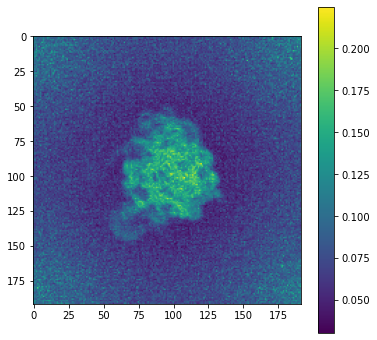

In [39]:
mip_z(vr_lbfgs_loaded)
plt.colorbar()

In [40]:
vrerr = jnp.abs(v_lbfgs - v_lbfgs_loaded)
print(jnp.max(vrerr)/jnp.max(jnp.abs(v_lbfgs)))
print(jnp.mean(vrerr)/jnp.max(jnp.abs(v_lbfgs)))

0.0
0.0


In [41]:
loss_lbfgs = loss_full_func(v_lbfgs, jnp.arange(N))
#loss_bfgs_loaded = loss_full_func(v_lbfgs_loaded, jnp.arange(N))

print(loss_lbfgs)
#print(loss_lbfgs_loaded)

1565735766.9736419


### Save/Load all the iterates

In [42]:
save_iterates = False
load_iterates = True

iterates_file_root = f"{out_dir}/iterates_{interp_method}/"

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_rec.npy", iterates_rec)
    jnp.save(f"{iterates_file_root}/iterates_rec_loss.npy", loss_rec)
    jnp.save(f"{iterates_file_root}/step_sizes_rec.npy", step_sizes_rec)

    jnp.save(f"{iterates_file_root}/iterates_p_rec1000.npy", iterates_p_rec1000)
    jnp.save(f"{iterates_file_root}/iterates_p_rec1000_loss.npy", loss_p_rec1000)
    jnp.save(f"{iterates_file_root}/step_sizes_p_rec1000.npy", step_sizes1000)

    jnp.save(f"{iterates_file_root}/iterates_o.npy", iterates_o)
    jnp.save(f"{iterates_file_root}/iterates_o_loss.npy", loss_o)
    jnp.save(f"{iterates_file_root}/step_sizes_o.npy", step_sizes_o)

if load_iterates:
    iterates_rec_loaded = jnp.load(f"{iterates_file_root}/iterates_rec.npy")
    loss_rec_loaded = jnp.load(f"{iterates_file_root}/iterates_rec_loss.npy")
    step_sizes_rec_loaded = jnp.load(f"{iterates_file_root}/step_sizes_rec.npy")

    #assert(jnp.max(jnp.abs(iterates_rec_loaded - jnp.array(iterates_rec))) == 0)
    #assert(jnp.max(jnp.abs(loss_rec_loaded - loss_rec)) == 0)
    #assert(jnp.max(jnp.abs(jnp.array(step_sizes_rec) - jnp.array(step_sizes_rec_loaded))) == 0)

    #del(iterates_rec_loaded)
    #del(loss_rec_loaded)
    #del(step_sizes_rec_loaded)

    iterates_p_rec1000_loaded = jnp.load(f"{iterates_file_root}/iterates_p_rec1000.npy")
    loss_p_rec1000_loaded = jnp.load(f"{iterates_file_root}/iterates_p_rec1000_loss.npy")
    step_sizes1000_loaded = jnp.load(f"{iterates_file_root}/step_sizes_p_rec1000.npy")

    #assert(jnp.max(jnp.abs(iterates_p_rec1000_loaded - jnp.array(iterates_p_rec1000))) == 0)
    #assert(jnp.max(jnp.abs(loss_p_rec1000_loaded - loss_p_rec1000)) == 0)
    #assert(jnp.max(jnp.abs(step_sizes1000_loaded - jnp.array(step_sizes1000))) == 0)

    #del(iterates_p_rec1000_loaded)
    #del(loss_p_rec1000_loaded)
    #del(step_sizes1000_loaded)

    iterates_o_loaded = jnp.load(f"{iterates_file_root}/iterates_o.npy")
    loss_o_loaded = jnp.load(f"{iterates_file_root}/iterates_o_loss.npy")
    step_sizes_o_loaded = jnp.load(f"{iterates_file_root}/step_sizes_o.npy")

    #assert(jnp.max(jnp.abs(iterates_o_loaded - jnp.array(iterates_o))) == 0)
    #assert(jnp.max(jnp.abs(loss_o_loaded - jnp.array(loss_o))) == 0)
    #assert(jnp.max(jnp.abs(step_sizes_o_loaded - jnp.array(step_sizes_o))) == 0)

    #del(iterates_o_loaded)
    #del(loss_o_loaded)
    #del(step_sizes_o_loaded)

In [43]:
iterates_rec = iterates_rec_loaded
iterates_p_rec1000 = iterates_p_rec1000_loaded
iterates_o = iterates_o_loaded

loss_rec = loss_rec_loaded
loss_p_rec1000 = loss_p_rec1000_loaded
loss_o = loss_o_loaded

step_sizes_rec = step_sizes_rec_loaded
step_sizes1000 = step_sizes1000_loaded
step_sizes_o = step_sizes_o_loaded

### Diagnostics

#### First: the loss and the step size

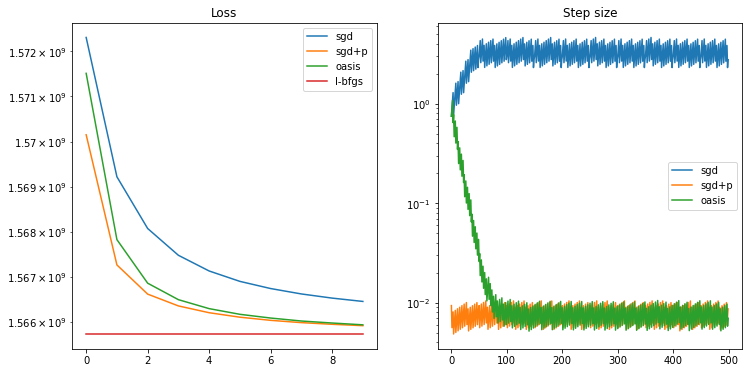

In [44]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec1000)
plt.semilogy(loss_o)
plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(['sgd', 'sgd+p', 'oasis', 'l-bfgs'])
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_rec)
plt.semilogy(step_sizes1000)
plt.semilogy(step_sizes_o)
plt.legend(['sgd', 'sgd+p', 'oasis'])
plt.title("Step size")

plt.rcParams["figure.figsize"]=6,6

#### Sanity check: recompute the losses using the individual iterates to make sure they agree with what the algorithm outputs

In [ ]:
loss_rec_post = []
for i, vv in enumerate(iterates_rec):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_rec_post.append(loss_full_func(vv, jnp.arange(N)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
plt.plot(loss_rec_post[1:])

In [ ]:
loss_p_rec1000_post = []
for i, vv in enumerate(iterates_p_rec1000):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_p_rec1000_post.append(loss_full_func(vv, jnp.arange(N)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
loss_p_rec5000_post = []
for i, vv in enumerate(iterates_p_rec5000):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_p_rec5000_post.append(loss_full_func(vv, jnp.arange(N)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
plt.plot(loss_rec_post[1:])
plt.plot(loss_p_rec1000_post[1:])
plt.plot(loss_p_rec2000_post[1:])
plt.plot(loss_p_rec5000_post[1:])
plt.legend(['sgd', 'sgd+p 1000', 'sgd+p 2000', 'sgd+p 5000'])

### The pixel-wise data loss doesn't seem to tell us much. 

In [ ]:
loss_rec_px = []
for i, vv in enumerate(iterates_rec):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_rec_px.append(loss_full_px_func(vv, jnp.arange(N)).reshape((nx,nx)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
plt.imshow(jnp.sqrt(jnp.fft.fftshift(loss_rec_px[-1])))
plt.colorbar()

In [ ]:
loss_p_rec1000_px = []
for i, vv in enumerate(iterates_p_rec1000):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_p_rec1000_px.append(loss_full_px_func(vv, jnp.arange(N)).reshape((nx,nx)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
loss_p_rec2000_px = []
for i, vv in enumerate(iterates_p_rec2000):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_p_rec2000_px.append(loss_full_px_func(vv, jnp.arange(N)).reshape((nx,nx)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
loss_p_rec5000_px = []
for i, vv in enumerate(iterates_p_rec5000):
    print(f"Iter {i}  ", end="")
    t0 = time.time()
    loss_p_rec5000_px.append(loss_full_px_func(vv, jnp.arange(N)).reshape((nx,nx)))
    t1 = time.time() - t0
    print(t1)

In [ ]:
loss_lbfgs_px = loss_full_px_func(v_lbfgs, jnp.arange(N)).reshape((nx,nx))


In [ ]:
plt.imshow(jnp.sqrt(jnp.fft.fftshift(loss_lbfgs_px)))
plt.colorbar()

### The full mean of these losses agrees with the overall loss

In [ ]:
llrec = [jnp.mean(li) for li in loss_rec_px]
llrec_p_1000 = [jnp.mean(li) for li in loss_p_rec1000_px]
llrec_p_2000 = [jnp.mean(li) for li in loss_p_rec2000_px]
llrec_p_5000 = [jnp.mean(li) for li in loss_p_rec5000_px]
llbfgs = jnp.mean(loss_lbfgs_px)

In [ ]:
plt.subplot(121)
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec1000)
plt.semilogy(loss_p_rec2000)
plt.semilogy(loss_p_rec5000)
plt.semilogy([loss_lbfgs] * 10)
plt.legend(['sgd', 'sgd+p 1000', 'sgd+p 2000', 'sgd+p 5000', 'lbfgs final'])
plt.title('Full loss')

plt.subplot(122)
plt.semilogy(llrec[1:])
plt.semilogy(llrec_p_1000[1:])
plt.semilogy(llrec_p_2000[1:])
plt.semilogy(llrec_p_5000[1:])
plt.semilogy([llbfgs] * 10)
plt.legend(['sgd', 'sgd+p 1000', 'sgd+p 2000', 'sgd+p 5000', 'lbfgs final'])
plt.title('Averaged pixel-wise loss (it excludes the regularization term)')

### But the shell-averaged data losses are useless

In [ ]:
from src.fsc import average_shells_2D

avloss_rec = [average_shells_2D(loss_rec_px[ii], x_grid) for ii in range(11)]
avloss_rec_p_1000 = [average_shells_2D(loss_p_rec1000_px[ii], x_grid) for ii in range(11)]
avloss_rec_p_2000 = [average_shells_2D(loss_p_rec2000_px[ii], x_grid) for ii in range(11)]
avloss_rec_p_5000 = [average_shells_2D(loss_p_rec5000_px[ii], x_grid) for ii in range(11)]

In [ ]:
# The radially averaged losses are useless though

idx = 10
plt.semilogy(avloss_rec[idx])
plt.semilogy(avloss_rec_p_1000[idx])
plt.semilogy(avloss_rec_p_2000[idx])
plt.semilogy(avloss_rec_p_5000[idx])

plt.legend(['sgd', 'sgd+p 1000', 'sgd+p 2000', 'sgd+p 5000'])

### Error and FSC (with the L-BFGS solution) in shells

In [45]:
from src.fsc import average_shells

def err_px(v1, v2):
    err = 1/2 * jnp.real(jnp.conj(v1-v2)*(v1-v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)
    
    return jnp.array([avg_err, max_err, median_err])

err_px_iterates = jax.vmap(lambda vv : err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1)

In [46]:
averr_rec, maxerr_rec, mederr_rec = err_px_iterates(jnp.array(iterates_rec))
averr_rec_p_1000, maxerr_rec_p_1000, mederr_rec_p_1000 = err_px_iterates(jnp.array(iterates_p_rec1000))
averr_rec_o, maxerr_rec_o, mederr_rec_o = err_px_iterates(jnp.array(iterates_o))

print(averr_rec.shape)
print(maxerr_rec.shape)
print(mederr_rec.shape)

(11, 55)
(11, 55)
(11, 55)


In [47]:
res, fsc_sgd, shell_pts = fsc_iterates(jnp.array(iterates_rec))
res, fsc_sgd_p, shell_pts = fsc_iterates(jnp.array(iterates_p_rec1000))
res, fsc_o, shell_pts = fsc_iterates(jnp.array(iterates_o))

print(fsc_sgd.shape)
print(fsc_sgd_p.shape)
print(fsc_o.shape)

(11, 55)
(11, 55)
(11, 55)


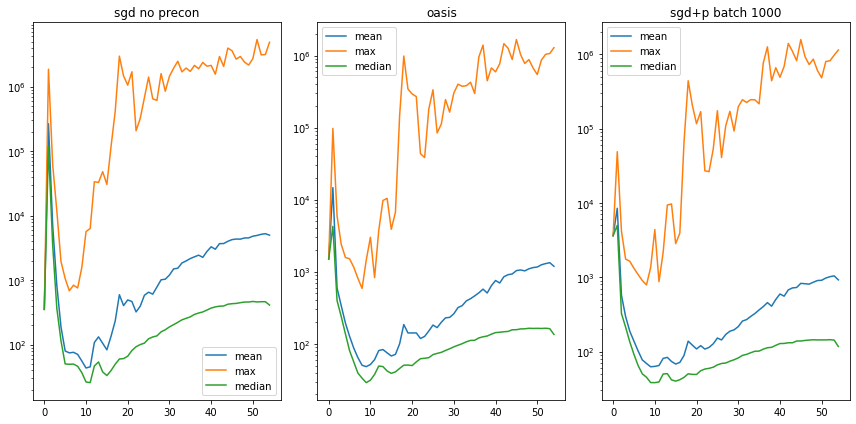

In [48]:
idx = 10

plt.rcParams["figure.figsize"]=12,6

plt.subplot(131)
plt.semilogy((averr_rec[idx]))
plt.semilogy((maxerr_rec[idx]))
plt.semilogy((mederr_rec[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd no precon')
plt.tight_layout()

plt.subplot(132)
plt.semilogy((averr_rec_o[idx]))
plt.semilogy((maxerr_rec_o[idx]))
plt.semilogy((mederr_rec_o[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('oasis')
plt.tight_layout()

plt.subplot(133)
plt.semilogy((averr_rec_p_1000[idx]))
plt.semilogy((maxerr_rec_p_1000[idx]))
plt.semilogy((mederr_rec_p_1000[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd+p batch 1000')

plt.rcParams["figure.figsize"]=6,6

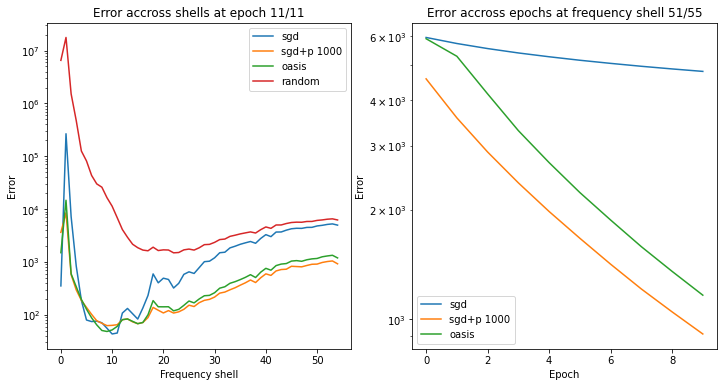

In [49]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogy(averr_rec[idx])
plt.semilogy(averr_rec_p_1000[idx])
plt.semilogy(averr_rec_o[idx])
plt.semilogy(averr_rec[0])

plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'random'])
plt.xlabel('Frequency shell')
plt.ylabel('Error')
plt.title(f'Error accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 50
plt.semilogy(averr_rec[1:,idx_shell])
plt.semilogy(averr_rec_p_1000[1:, idx_shell])
plt.semilogy(averr_rec_o[1:, idx_shell])

plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Error accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

#### The resolution in Angs
If ``res``, the radius in the Fourier domain, goes from 0 to R, where $R \approx \frac{Npixels}{2}$, 
then ``res_angs(res)``$=\frac{N0 pixels \times px0}{res}$,
where ``N0pixels``= number of pixels in the original images (here 320) 
and ``px0`` = pixel size (here 1.33 Angs), 
so ``res_angs`` goes from ``N0pixels x px0`` to ``N0pixels x px0 x 2 / Npixels``

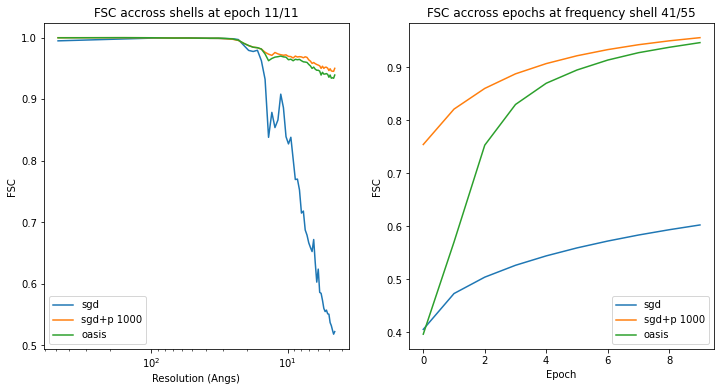

In [50]:
res_angs = nx0 * pixel_size[0]/res[0]

plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_sgd[idx,1:])
plt.semilogx(res_angs[1:], fsc_sgd_p[idx,1:])
plt.semilogx(res_angs[1:], fsc_o[idx,1:])

plt.gca().invert_xaxis()
plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Resolution (Angs)')
plt.ylabel('FSC')
plt.title(f'FSC accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 40
plt.plot(fsc_sgd[1:,idx_shell])
plt.plot(fsc_sgd_p[1:, idx_shell])
plt.plot(fsc_o[1:, idx_shell])

plt.legend(['sgd', 'sgd+p 1000', 'oasis'])
plt.xlabel('Epoch')
plt.ylabel('FSC')
plt.title(f'FSC accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

### FSC heatmap for Fourier shell vs epoch

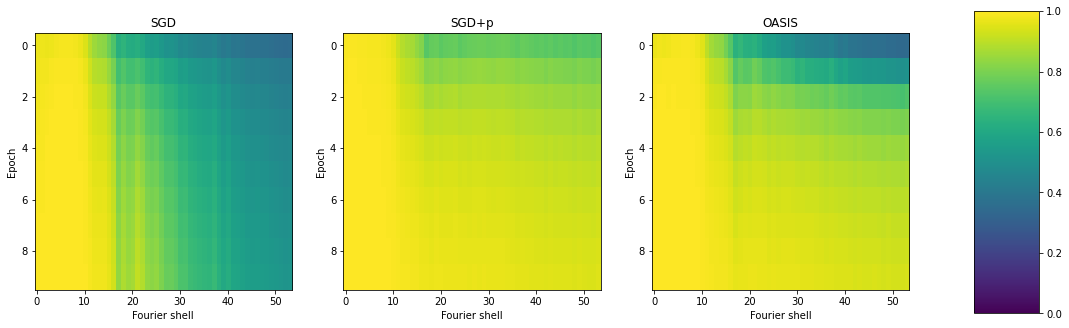

In [51]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.rcParams["figure.figsize"]=18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_sgd[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD')

ax = fig.add_subplot(132)
ax.imshow(fsc_sgd_p[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD+p')

ax = fig.add_subplot(133)
im = ax.imshow(fsc_o[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('OASIS')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

#### Also look at the preconditioner

In [58]:
_, precon_radial_mean, _,  precon_radial_max, precon_radial_median = average_shells((1/D0hat), x_grid)
_, D0_radial_mean, _,  D0_radial_max, D0_radial_median = average_shells(D0hat, x_grid)

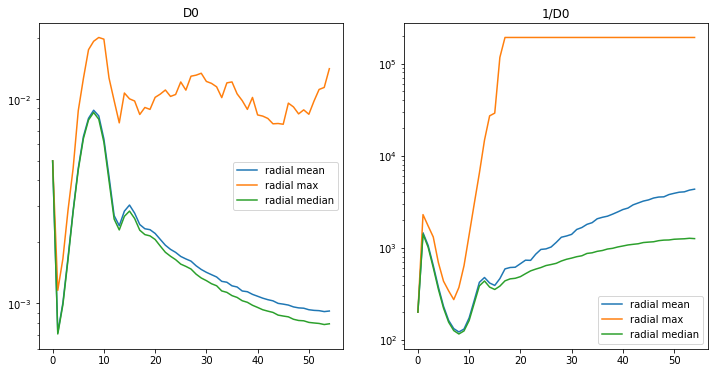

In [59]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('D0')

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('1/D0')

plt.rcParams["figure.figsize"]=6,6

### The variance of the gradients

In [ ]:
key = random.PRNGKey(45)
vol = iterates_rec[5]

In [ ]:
def compute_grad_variance(key, v, batch_size, P = None):
    idxs_rand = random.permutation(key, jnp.arange(N))
    N_batch = int(N/batch_size)
    
    if P is None:
        P = jnp.ones(v.shape)
    
    # Doing this on GPU with JAX takes _extremely_ long to compile. 
    # DO NOT ATTEMPT !!!
    idx_batches = jnp.array(np.array_split(np.array(idxs_rand), N_batch)) 
    
    grads = []
    for idx in tqdm(idx_batches):
        grads.append(grad_full_func(v, idx))
        
    grads = P * jnp.array(grads)
    
    mean_grad = jnp.mean(grads, axis=0)
    var_grad = jnp.var(grads, axis=0)
    
    return mean_grad, var_grad


In [ ]:
grad_full = grad_full_func(vol, jnp.arange(N))

In [ ]:
vol = iterates_rec[5]

mean_grad_1000, var_grad_1000 = compute_grad_variance(key, vol, 1000)
#mean_grad_2000, var_grad_2000 = compute_grad_variance(key, vol, 2000)
#mean_grad_5000, var_grad_5000 = compute_grad_variance(key, vol, 5000)

# Sanity checks
assert(jnp.max(jnp.abs(mean_grad_1000 - grad_full)) < 1e-14)
#assert(jnp.max(jnp.abs(mean_grad_2000 - grad_full)) < 1e-14)
#assert(jnp.max(jnp.abs(mean_grad_5000 - grad_full)) < 1e-14)

In [ ]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid)  # The median computation doesn't like complex numbers
_, av_var_grad_1000, _, _, _ = average_shells(var_grad_1000, x_grid)
#_, av_var_grad_2000, _, _, _ = average_shells(var_grad_2000, x_grid)
#_, av_var_grad_5000, _ = average_shells(var_grad_5000, x_grid)

In [ ]:
plt.semilogy(jnp.abs(avgrad_full[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000[:45]))
#plt.semilogy(jnp.abs(av_var_grad_2000[:45]))
#plt.semilogy(jnp.abs(av_var_grad_5000))

plt.title('Variance of the non-preconditioned gradients')

plt.legend(['mean grad', 'var grad 1000', 'var grad 2000', 'var grad 5000'])
#plt.legend([ 'var grad 1000', 'var grad 2000', 'var grad 5000'])

In [ ]:
grad_full_p = 1/D0hat * grad_full

mean_grad_1000_p, var_grad_1000_p = compute_grad_variance(key, vol, 1000, 1/D0hat)
#mean_grad_2000_p, var_grad_2000_p = compute_grad_variance(key, vol, 2000, 1/D0hat)
#mean_grad_5000_p, var_grad_5000_p = compute_grad_variance(key, vol, 5000, 1/D0)

In [ ]:
# Sanity checks
assert(jnp.max(jnp.abs(mean_grad_1000_p - grad_full_p)) < 1e-11)
#assert(jnp.max(jnp.abs(mean_grad_2000_p - grad_full_p)) < 1e-9)
#assert(jnp.max(jnp.abs(mean_grad_5000_p - grad_full_p)) < 1e-10)

In [ ]:
jnp.max(jnp.abs(mean_grad_1000_p - grad_full_p))

In [ ]:
_, avgrad_full_p, _ , _, _= average_shells(jnp.abs(grad_full_p), x_grid) # The median computation doesn't like complex numbers
_, av_var_grad_1000_p, _, _, _= average_shells(var_grad_1000_p, x_grid)
#_, av_var_grad_2000_p, _, _, _= average_shells(var_grad_2000_p, x_grid)
#_, av_var_grad_5000_p, _ = average_shells(var_grad_5000_p, x_grid)

In [ ]:
plt.semilogy(jnp.abs(avgrad_full_p[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000_p[:45]))
#plt.semilogy(jnp.abs(av_var_grad_2000_p[:45]))
#plt.semilogy(jnp.abs(av_var_grad_5000_p))
#plt.semilogy(precon_radial_mean)

plt.title('Variance of the preconditioned gradients')

plt.legend(['mean grad', 'var grad 1000', 'var grad 2000', 'var grad 5000'])

#### The error and the variance of the _preconditioned_ gradient go up at the same time, so they are related, so maybe their common thing is the problem: the preconditioner

In [ ]:
plt.semilogy(averr_rec_p_1000[10][:45])
plt.semilogy(jnp.abs(av_var_grad_1000_p[:50][:45]))


#### Random plots of the (intermediate) reconstructions and errors

In [ ]:
slice_idx = 0

err_rec = jnp.max(jnp.abs(jnp.fft.fftshift(iterates_rec[-1]-v_lbfgs)), axis=2)
#plt.imshow(err_rec)
plt.imshow(jnp.max(jnp.abs(jnp.fft.fftshift(iterates_rec[-1])), axis=2), vmin=0, vmax=8000)
plt.colorbar()

print(jnp.sum(jnp.abs(iterates_rec[-1]) > 6000))
print(jnp.sum(err_rec > 8000))

In [ ]:
err_rec_p = jnp.max(jnp.abs(jnp.fft.fftshift(iterates_p_rec5000[-1]-v_lbfgs)), axis=2)

#plt.imshow(err_rec_p)
plt.imshow(jnp.max(jnp.abs(jnp.fft.fftshift(iterates_p_rec5000[-9])), axis=2), vmin=0, vmax=8000); 
plt.colorbar()

print(jnp.sum(jnp.abs(iterates_p_rec1000[10]) > 8000))
#print(jnp.sum(err_rec_p > 8000))

In [ ]:
plt.imshow(jnp.max(jnp.abs(jnp.fft.fftshift(v_lbfgs[:,:,:])), axis=2), vmax=8000); 
plt.colorbar()

print(jnp.sum(jnp.abs(v_lbfgs) > 6000))


In [ ]:
plt.imshow(jnp.max(jnp.fft.fftshift(jnp.abs(vvv)), axis=2), vmax=8000); plt.colorbar()

### FSC with the ground truth

In [ ]:
res_sgd, fsc_sgd, shell_points = calc_fsc(v_lbfgs, v_rec, [1, nx_crop])
res_sgd_p, fsc_sgd_p, shell_points = calc_fsc(v_lbfgs, v_p_rec, [1, nx_crop])
res_oasis, fsc_oasis, shell_points = calc_fsc(v_lbfgs, v_rec_o, [1, nx_crop])

In [ ]:
res_angs = nx0 * pixel_size[0]/res_sgd
print(f"Max resolution = {res_angs[-1]:0.02f} angs")
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_sgd_p)
plt.semilogx(res_angs, fsc_oasis)

plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "SGD+p", "OASIS"])
#plt.legend(["SGD", "SGD+p"])

### Bonus: CG

In [ ]:
with jax.default_device(jax.devices('cpu')[0]):
    AA, Ab = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles, shifts, ctf_params, imgs_f, v_rec.shape, sigma_noise)


In [ ]:
N_iter = 1


In [ ]:
t0 = time.time()
v_rec_cg, k, v_rec_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
t1 = time.time() - t0

In [ ]:
print(t1)

In [ ]:
loss_cg = jax.vmap(loss_func, in_axes = (0, None))(jnp.array(v_rec_cg_all), jnp.arange(N))

In [ ]:
mip_z(np.fft.fftshift(np.abs(v_rec_cg))); plt.colorbar()

In [ ]:
v_rec_cgl, _ = rescale_larger_grid(v_rec_cg, x_grid, nx0)
vr_cg = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl)))

mip_z(vr_cg)
plt.colorbar()

In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg.astype(np.float32))

In [ ]:
plt.plot(loss_rec)
plt.plot(loss_p_rec)
plt.plot(loss_o)
plt.plot(loss_cg)

plt.plot(loss_bfgs*jnp.ones(loss_rec.shape))

plt.legend(["SGD", "SGD+p", "OASIS", "CG", "BFGS"])

In [ ]:
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#
#res_angs = nx0 * pixel_size[0]/res
#plt.semilogx(res_angs, fsc_cg)
#plt.gca().invert_xaxis()
#plt.title("FSC")

In [ ]:
loss_x0 = loss_func(x0, jnp.arange(N)) * jnp.ones((N_iter,))

In [ ]:
print(loss_func(v_rec, jnp.arange(N)))
print(loss_func(v_p_rec, jnp.arange(N)))
print(loss_func(v_lbfgs, jnp.arange(N)))
print(loss_func(v_rec_o, jnp.arange(N)))
print(loss_func(v_rec_cg, jnp.arange(N)))

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* The Armijo line search works well with c=0.99.